# Multiclass Logistic Regression with SGD
Implementation of multiple class logistic regression on the MNIST dataset, using stochastic gradient descent. (The code here got really ugly towards the end...)

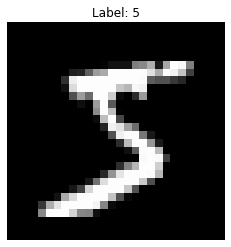

In [5]:
import numpy as np
import matplotlib.pyplot as plt

# Import the MNIST data
from tensorflow.keras.datasets import mnist as keras_mnist
(X_train, ytr), (X_test, yte) = keras_mnist.load_data()

# Normalizing data
def normalize(X):
    n, px, py = X.shape
    Xr = X.reshape(n, px * py)
    
    m = np.mean(Xr, axis=1).reshape(n,1)
    s = np.std(Xr, axis=1).reshape(n,1)
    
    return (Xr - m) / s

Xtr = normalize(X_train)
Xte = normalize(X_test)

plt.imshow(Xtr[0].reshape(28,28), cmap='gray')
plt.axis('off')
plt.title('Label: %d' % ytr[0])
plt.show()

## Problem setup

* Examples: $X \in \mathbb{R}^{N\times{D}}$, labels: $\mathbf{y}\in\{0\dots K\}^N$
* Weights matrix: $W \in \mathbb{R}^{K\times D}$
* Prediction for $\mathbf{x_i}$: Index $j$ of $W\mathbf{x}_i$ with largest value
* Logistic loss for example $\mathbf{x}_i$: $l_i(W)=\log\left(\sum_{k=1}^{K}\exp(\mathbf{w}_k\cdot\mathbf{x}_i)\right)-\mathbf{w}_{y_i}\cdot\mathbf{x}_i$
* Loss: $\mathcal{L}(W)=\frac1{|S|}\sum_{i\in{S}} l_i(W)$

We will be using SGD, so let's first find the gradient of $\mathcal{L}$ w.r.t $W$:

$$
\begin{align}
    [\nabla_W l_i(W)]_{j*}
    =\frac{\partial l_i}{\partial\mathbf{w_j}}
    &=\frac\partial{\partial\mathbf{w_j}}\left[\log\left(\sum_{k=1}^{K}\exp(\mathbf{w}_k\cdot\mathbf{x}_i)\right)-\mathbf{w}_{y_i}\cdot\mathbf{x}_i\right] \\
    &=\frac{\exp(\mathbf{w}_j\cdot\mathbf{x}_i)\mathbf{x}_i^\top}
      {\sum_{k=1}^{K}\exp(\mathbf{w}_k\cdot\mathbf{x}_i)} - \frac{\partial(\mathbf{w}_{y_i}\cdot\mathbf{x}_i)}{\partial\mathbf{w_j}} \\
     &=\left[\frac{\exp(\mathbf{w}_j\cdot\mathbf{x}_i)}
      {\sum_{k=1}^{K}\exp(\mathbf{w}_k\cdot\mathbf{x}_i)} - \mathbf1[y_i=j]\right]\mathbf{x}_i^\top
\end{align}
$$

Define $\mathbf{v}_i=\begin{bmatrix}v_{i1} & \dots & v_{iK}\end{bmatrix}^\top$, where $v_{ij}=\frac{\exp(\mathbf{w}_j\cdot\mathbf{x}_i)}
      {\sum_{k=1}^{K}\exp(\mathbf{w}_k\cdot\mathbf{x}_i)} - \mathbf1[y_i=j]$, then:
      
$$
    \frac{\partial l_i}{\partial W}=\begin{bmatrix}
        v_{i1}\mathbf{x}_i^\top \\
        \vdots \\
        v_{iK}\mathbf{x}_i^\top \\
    \end{bmatrix} = \mathbf v_i\mathbf x_i^\top
$$

and,

$$
    \nabla_W \mathcal{L}(W)=\frac1{|S|}\sum_{i\in{S}} \nabla_W l_i=\frac1{|S|} \sum_{i\in S} \mathbf{v}_i\mathbf x_i^\top
$$

In [6]:
def loss(X, y, W):
    Z = np.exp(np.matmul(W, X.transpose()))
    N = np.sum(Z, axis = 0)
    total = 0
    for i, x in enumerate(X):
        w_yi = W[y[i]-1]
        total += (np.log(N[i]) - np.dot(w_yi,x))
    
    return total / X.shape[0]
    

def get_v(x, y, W, z, norm):
    v = z / norm
    v[y-1] = v[y-1] - 1
    return v

def gradient(X, y, W, k, Z, N):
    n, d = X.shape
    g = np.zeros((k, d))
    
    for i, x in enumerate(X):
        v = get_v(x, y[i], W, Z[:,i], N[i])
        g += np.outer(v, x)
    
    return g / n

With `get_v` and `gradient` implemented, we are ready for SGD.

In [7]:
# Mini batch sampling
class Sample_idx:
    def __init__(self, n):
        self.n = n
        self.prm = []
        
    def sample(self):
        if len(self.prm) == 0:
            self.prm = np.random.permutation(self.n)
            idx, self.prm = self.prm[-1], self.prm[:-1]
        else:
            idx, self.prm = self.prm[-1], self.prm[:-1]
        
        return idx

# SGD
def sgd(X, y, k):
    n, d = X.shape
    
    epochs = 20
    bs = 1000
    nbs = int(n/bs)
    sampler = Sample_idx(nbs)
    
    W = np.zeros((k,d))
    
    losses = [loss(X, y, W)]
    
    for e in range(1, epochs * nbs):
        # getting a mini batch
        head = sampler.sample() * bs
        Xt, yt = X[head:head + bs], y[head:head + bs]
        
        # All confidences and norms
        Z = np.exp(np.matmul(W, Xt.transpose()))
        N = np.sum(Z, axis = 0)
        
        Wgt = gradient(Xt, yt, W, k, Z, N)
        W -= 0.1*Wgt

        if e % nbs == 0:
            losses.append(loss(X, y, W))
    
    return W, losses

In [8]:
W, losses = sgd(Xtr, ytr, 10)

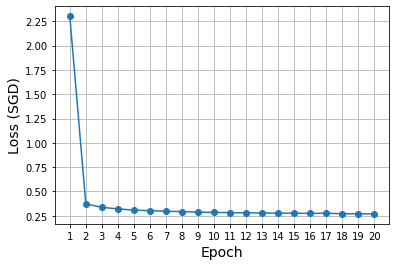

In [9]:
# plot the loss over time
plt.plot(range(1, 1+len(losses)), losses, linestyle='-', marker='o')
plt.grid()
xt = np.arange(1, 1+len(losses), 1)
_ = plt.xticks(xt)
_ = plt.xlabel('Epoch', fontsize=14)
_ = plt.ylabel('Loss (SGD)', fontsize=14)
plt.show()

Here, I visualize the weights achieved for each class by multiple logistic regression

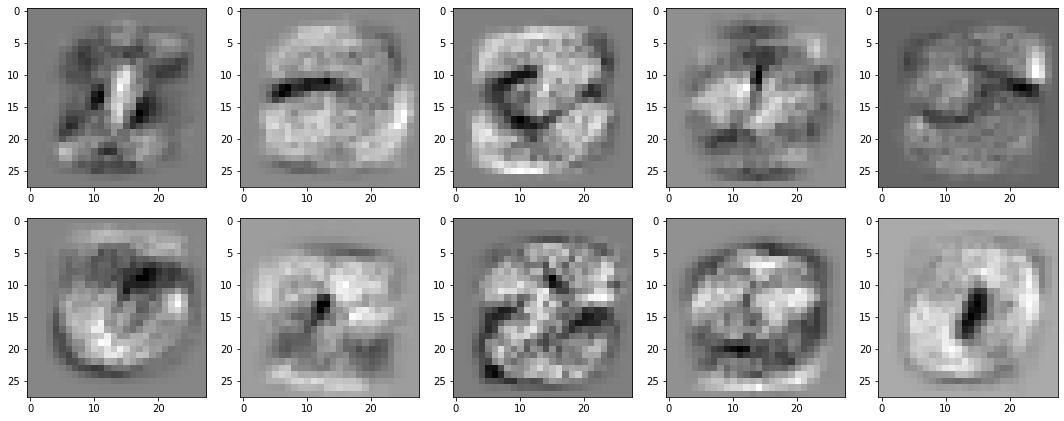

In [10]:
weights = W.reshape(10, 28, 28)
fig, axes = plt.subplots(2, 5, figsize=(15,6))
for r in range(2):
    for c in range(5):
        fig.tight_layout()
        axes[r,c].imshow(weights[r*5+c],cmap='gray')

In [11]:
results = np.matmul(W, Xte.transpose())
preds = (1 + np.argmax(results, axis=0)) % 10

In [12]:
print('First 20 predicted labels:', preds[:20])
print('First 20 correct labels:  ', yte[:20])
print('Accuracy:                 ', np.mean(preds == yte))

First 20 predicted labels: [7 2 1 0 4 1 4 9 6 9 0 6 9 0 1 5 9 7 3 4]
First 20 correct labels:   [7 2 1 0 4 1 4 9 5 9 0 6 9 0 1 5 9 7 3 4]
Accuracy:                  0.922


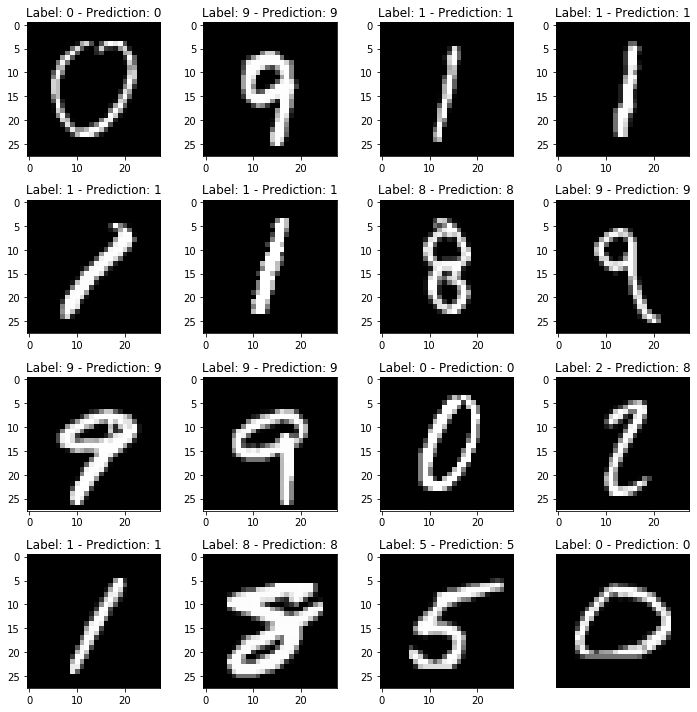

In [13]:
# Example
idx = np.random.choice(Xte.shape[0], 16)
examples = Xte[idx].reshape(16,28,28)
y_ex = yte[idx]
p_ex = preds[idx]

fig, axes = plt.subplots(4, 4, figsize=(10,10))
plt.axis('off')
for r in range(4):
    for c in range(4):
        i = r * 4 + c
        fig.tight_layout()
        title = 'Label: %d - Prediction: %d' % (y_ex[i], p_ex[i])
        axes[r,c].set_title(title)
        axes[r,c].imshow(examples[i], cmap='gray')
plt.show()